# PART A: CLASSIFICATION (50 marks)

**Done by:**<br>Randy See Meng Teck<br>p2021669<br>DAAA/FT/2A/05

## 1. Import libraries

In [1]:
# Others
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from random import sample
import re
import seaborn as sns
import statistics as stat
import time
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

## 2. Import datasets

In [2]:
# Import dataset from <agaricus-lepiota.names>
df_names =  open('./agaricus-lepiota.names', 'r').read()
print(df_names)

1. Title: Mushroom Database

2. Sources: 
    (a) Mushroom records drawn from The Audubon Society Field Guide to North
        American Mushrooms (1981). G. H. Lincoff (Pres.), New York: Alfred
        A. Knopf
    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    (c) Date: 27 April 1987

3. Past Usage:
    1. Schlimmer,J.S. (1987). Concept Acquisition Through Representational
       Adjustment (Technical Report 87-19).  Doctoral disseration, Department
       of Information and Computer Science, University of California, Irvine.
       --- STAGGER: asymptoted to 95% classification accuracy after reviewing
           1000 instances.
    2. Iba,W., Wogulis,J., & Langley,P. (1988).  Trading off Simplicity
       and Coverage in Incremental Concept Learning. In Proceedings of 
       the 5th International Conference on Machine Learning, 73-79.
       Ann Arbor, Michigan: Morgan Kaufmann.  
       -- approximately the same results with their HILLARY algorithm    
    3. In 

In [3]:
# Import dataset from <agaricus-lepiota.data>
df = pd.read_csv("./agaricus-lepiota.data", header=None)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m


*The indexes in the data file are not labelled, lets clean up the names file to generate column names

## 3. Data cleaning

### 3.1. Structuring data

In [4]:
# Slice attribute information
df_names = df_names[slice(4304,6609)]
print(df_names)

# Convert attribute information from raw text into dictionary
def convert(string):
    pattern = re.compile(r'\s+|[0-9()]+')
    string = re.sub(pattern, '', string)
    array_1d = string.split(".")
    array_2d = []
    for i in array_1d:
        array_2d.append(i.split(":"))
    array_3d = []
    for j,k in array_2d:
        array_3d.append([j,k.split(",")])
    dicts = {}
    for l in range(len(array_3d)):
        array_dict = {}
        for m in array_3d[l][1]:
            array_dict[m.split("=")[1]] = m.split("=")[0]
            dicts[array_3d[l][0]] = array_dict
    return dicts

attr = convert(df_names)

# Create data dictionary
data = {"attr_info": attr, "attr_names": attr.keys()}

data['attr_names']

(classes: edible=e, poisonous=p)
     1. cap-shape:                bell=b,conical=c,convex=x,flat=f,
                                  knobbed=k,sunken=s
     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r,
                                  pink=p,purple=u,red=e,white=w,yellow=y
     4. bruises?:                 bruises=t,no=f
     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f,
                                  musty=m,none=n,pungent=p,spicy=s
     6. gill-attachment:          attached=a,descending=d,free=f,notched=n
     7. gill-spacing:             close=c,crowded=w,distant=d
     8. gill-size:                broad=b,narrow=n
     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g,
                                  green=r,orange=o,pink=p,purple=u,red=e,
                                  white=w,yellow=y
    10. stalk-shape:              enlargin

dict_keys(['classes', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'])

*Slice the raw text into a dictionary

### 3.2. Labelling data

In [5]:
# Add column names for indexes
df.columns = data['attr_names']
df.head(3)

,classes,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m


*Label the columns for the indexes

### 3.3. Checking for missing values

In [6]:
# Convert '?' to NaN
df[df == '?'] = np.nan

# Print the number of NaNs
print(df.isnull().sum())

classes                        0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises?                       0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64


*There are missing values in stalk-root labelled as '?'

### 3.4. Remove missing value observations

In [7]:
# Print shape of original DataFrame
print("Shape of original dataframe:", df.shape)

# Drop column veil-type
df.dropna(axis=1, inplace=True)

# Print shape of new DataFrame
print("Shape of dataframe after dropping columns with missing values:", df.shape)

Shape of original dataframe: (8124, 23)
Shape of dataframe after dropping columns with missing values: (8124, 22)


*I decided to drop the column to minimise data loss as losing 8124 rows * 1 column is better than losing 2480 rows * 23 columns

### 3.5. Identify single-valued columns

In [8]:
print(df.nunique().sort_values(ascending=True).reset_index(name='count'))

                       index  count
0                  veil-type      1
1                    classes      2
2                  gill-size      2
3               gill-spacing      2
4            gill-attachment      2
5                stalk-shape      2
6                   bruises?      2
7                ring-number      3
8                cap-surface      4
9   stalk-surface-above-ring      4
10  stalk-surface-below-ring      4
11                veil-color      4
12                 ring-type      5
13                population      6
14                 cap-shape      6
15                   habitat      7
16    stalk-color-above-ring      9
17    stalk-color-below-ring      9
18         spore-print-color      9
19                      odor      9
20                 cap-color     10
21                gill-color     12


*Single-valued columns are redundant

### 3.6. Delete single-valued columns

In [9]:
# Print shape of original DataFrame
print("Shape of Original DataFrame: ", df.shape)

# Drop column veil-type
df = df.drop(['veil-type'], axis=1)

# Print shape of new DataFrame
print("Shape of DataFrame After Dropping All Rows with Missing Values: ", df.shape)

Shape of Original DataFrame:  (8124, 22)
Shape of DataFrame After Dropping All Rows with Missing Values:  (8124, 21)


*Remove single-valued column veil-type

### 3.7. Check for duplicates

In [10]:
# Check if there are duplicates
dups = df.duplicated()
print(dups.any())

# List all duplicate rows
print(df[dups])

False
Empty DataFrame
Columns: [classes, cap-shape, cap-surface, cap-color, bruises?, odor, gill-attachment, gill-spacing, gill-size, gill-color, stalk-shape, stalk-surface-above-ring, stalk-surface-below-ring, stalk-color-above-ring, stalk-color-below-ring, veil-color, ring-number, ring-type, spore-print-color, population, habitat]
Index: []

[0 rows x 21 columns]


*Check for duplicates as they as redundant as well

In [11]:
for col in df.columns:
    print(col, df[col].unique())

classes ['p' 'e']
cap-shape ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ['s' 'y' 'f' 'g']
cap-color ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises? ['t' 'f']
odor ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ['f' 'a']
gill-spacing ['c' 'w']
gill-size ['n' 'b']
gill-color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ['e' 't']
stalk-surface-above-ring ['s' 'f' 'k' 'y']
stalk-surface-below-ring ['s' 'f' 'y' 'k']
stalk-color-above-ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-color ['w' 'n' 'o' 'y']
ring-number ['o' 't' 'n']
ring-type ['p' 'e' 'l' 'f' 'n']
spore-print-color ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['s' 'n' 'a' 'v' 'y' 'c']
habitat ['u' 'g' 'm' 'd' 'p' 'w' 'l']


*Visualise the attributes we have for all features and target

## 4. Exploratory Data Anaylsis

### 4.1. Anatomy of a mushroom

<img src='./mushroom-anatomy.png' width="800" height="800">

*I am no mushroom expert, the only thing I know is that colorful mushrooms are poisonous, thus I researched more.

### 4.2. Descriptive statistics

In [12]:
df.describe(include='all')

,classes,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,4,9,9,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,s,w,w,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,5176,4936,4464,4384,7924,7488,3968,2388,4040,3148


### 4.3. Visualise data distribution

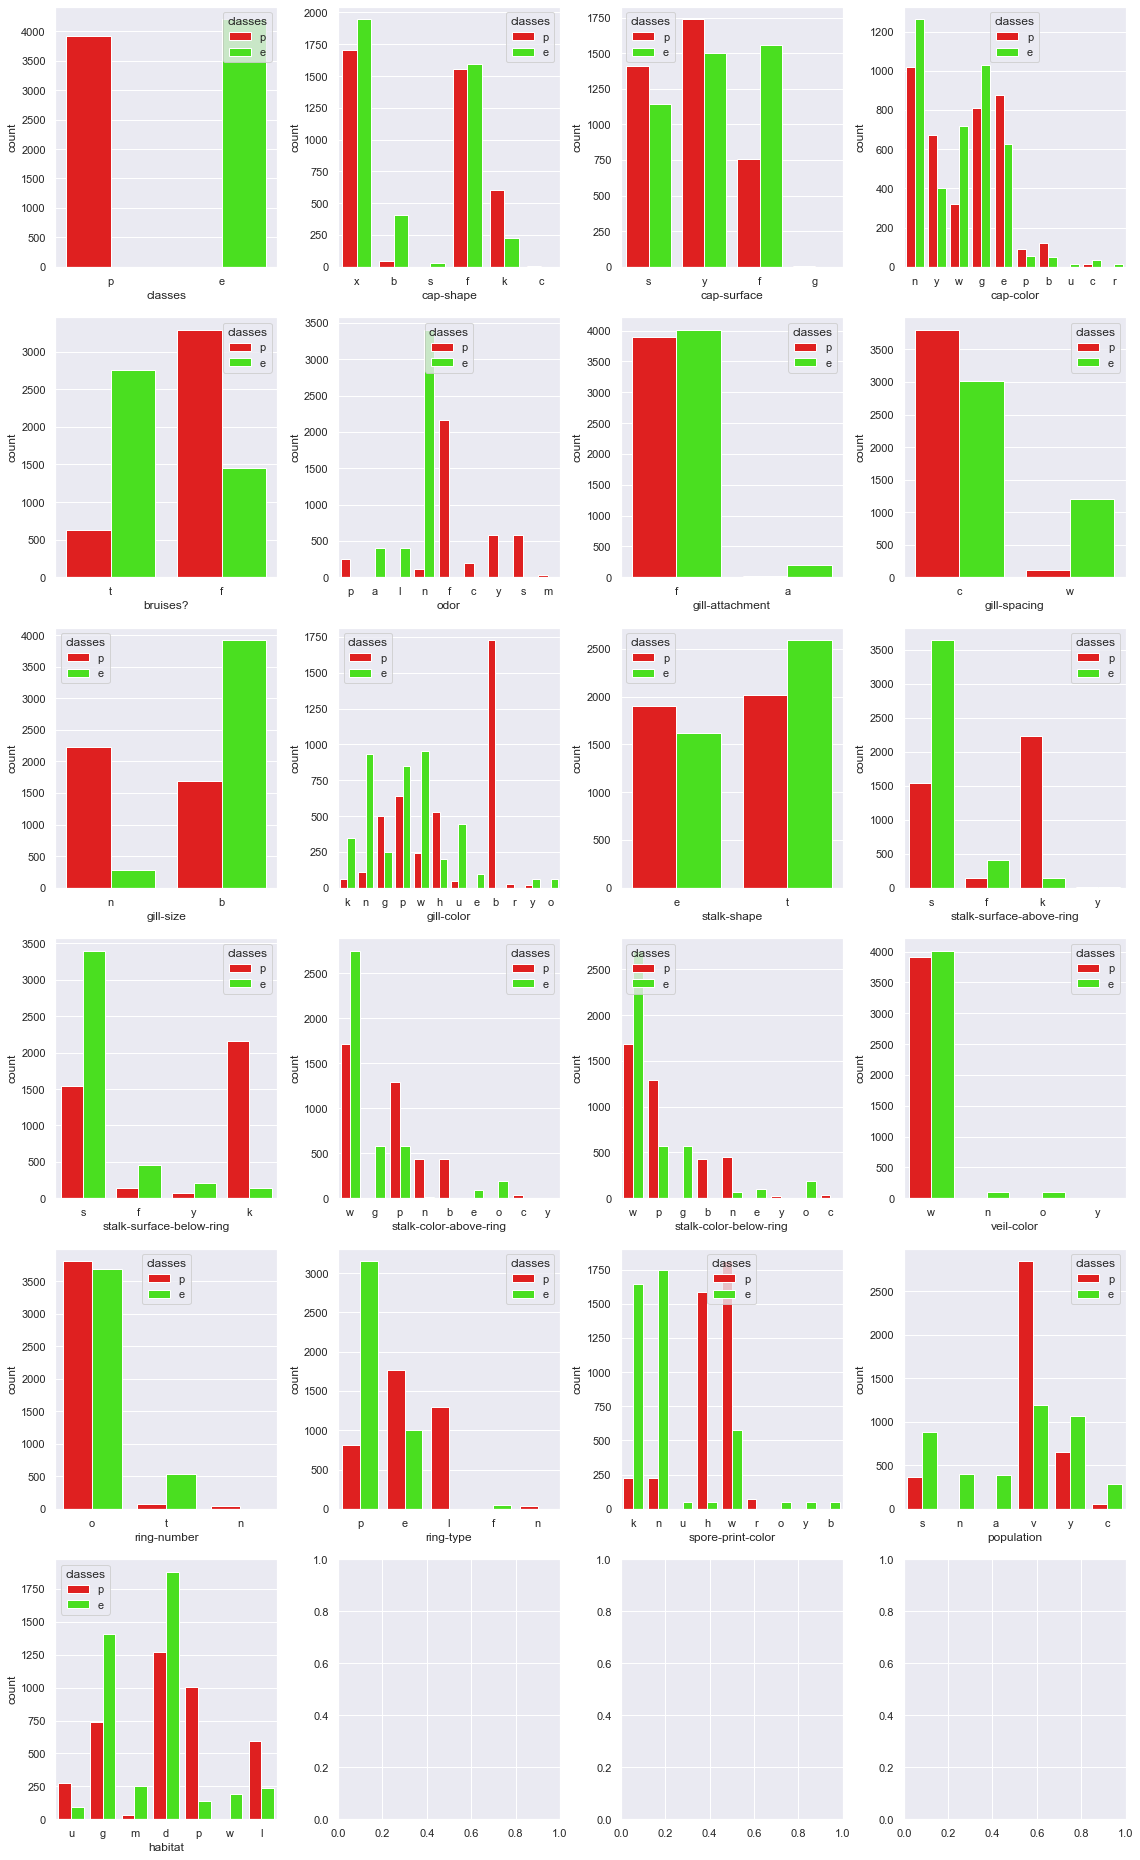

In [13]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(6,4, figsize=(16,26), sharex=False)
axes = axes.flatten()[:len(df.columns)]
for ax, catplot in zip(axes, df.columns):
    sns.countplot(x=catplot, hue="classes", data=df, ax=ax, dodge=True, palette=['#ff0000','#38ff00'])
plt.tight_layout()
plt.show()

*My hypothesis is that some of these targets would intercept each other and be able to form clusters

### 4.4. Check for clusterability

In [14]:
X = df.drop('classes', axis=1, inplace=False)
X = pd.get_dummies(X,drop_first=True)
df_pca = X
df_pca = df_pca.iloc[:, 0:2]
scaler = StandardScaler()
df_s = scaler.fit_transform(df_pca)

pd.DataFrame(df_s).head(3)

,0,1
0,-0.022195,-0.79621
1,-0.022195,-0.79621
2,-0.022195,-0.79621


*Scale the features into 2PCs to check for clusterability

In [15]:
d = df_s.shape[1] # columns
n = len(X) # rows
m = int(0.1 * n) # heuristic
nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(df_s)

rand_X = sample(range(0, n, 1), m)

ujd = []
wjd = []
for j in range(0, m):
    u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), 2, return_distance=True)
    ujd.append(u_dist[0][1])
    w_dist, _ = nbrs.kneighbors(df_s[rand_X[j]].reshape(1, -1), 2, return_distance=True)
    wjd.append(w_dist[0][1])

H = sum(ujd) / (sum(ujd) + sum(wjd))
print("Clusterability:",H)

Clusterability: 1.0


*It is perfectly clusterable. My hypothesis is that clustering classification will work best with the dataset

## 5. Feature engineering

In [16]:
# Import dataset from <agaricus-lepiota.names>
df_names =  open('./agaricus-lepiota.names', 'r').read()
print(df_names[slice(2418,3147)])

Logical rules for the mushroom data sets.

	Logical rules given below seem to be the simplest possible for the
	mushroom dataset and therefore should be treated as benchmark results.

	Disjunctive rules for poisonous mushrooms, from most general
	to most specific:

	P_1) odor=NOT(almond.OR.anise.OR.none)
	     120 poisonous cases missed, 98.52% accuracy

	P_2) spore-print-color=green
	     48 cases missed, 99.41% accuracy
         
	P_3) odor=none.AND.stalk-surface-below-ring=scaly.AND.
	          (stalk-color-above-ring=NOT.brown) 
	     8 cases missed, 99.90% accuracy
         
	P_4) habitat=leaves.AND.cap-color=white
	         100% accuracy     

	Rule P_4) may also be

	P_4') population=clustered.AND.cap_color=white


*Logical rules I read from the agaricus-lepiota.names file

In [17]:
df['P1'] = np.where(((df['odor'] == 'a') | (df['odor'] == 'l') | (df['odor'] == 'n')), 'p', 'e')
df['P2'] = np.where((df['spore-print-color'] == 'r'), 'e', 'p')
df['P3'] = np.where(((df['odor'] == 'n') & (df['stalk-surface-below-ring'] == 'y') & (df['stalk-color-above-ring'] != 'n')), 'e', 'p')
df['P4'] = np.where((df['habitat'] + df['cap-color'] == 'lw') | (df['population'] + df['cap-color'] == 'cw'), 'e', 'p')
df.head(3)

,classes,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,veil-color,ring-number,ring-type,spore-print-color,population,habitat,P1,P2,P3,P4
0,p,x,s,n,t,p,f,c,n,k,...,w,o,p,k,s,u,e,p,p,p
1,e,x,s,y,t,a,f,c,b,k,...,w,o,p,n,n,g,p,p,p,p
2,e,b,s,w,t,l,f,c,b,n,...,w,o,p,n,n,m,p,p,p,p


In [18]:
for col in df.columns:
    print(col, df[col].unique())

classes ['p' 'e']
cap-shape ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ['s' 'y' 'f' 'g']
cap-color ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises? ['t' 'f']
odor ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ['f' 'a']
gill-spacing ['c' 'w']
gill-size ['n' 'b']
gill-color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ['e' 't']
stalk-surface-above-ring ['s' 'f' 'k' 'y']
stalk-surface-below-ring ['s' 'f' 'y' 'k']
stalk-color-above-ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-color ['w' 'n' 'o' 'y']
ring-number ['o' 't' 'n']
ring-type ['p' 'e' 'l' 'f' 'n']
spore-print-color ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['s' 'n' 'a' 'v' 'y' 'c']
habitat ['u' 'g' 'm' 'd' 'p' 'w' 'l']
P1 ['e' 'p']
P2 ['p' 'e']
P3 ['p' 'e']
P4 ['p' 'e']


*Visualise new features

## 6. Feature selection

In [19]:
y = df['classes']
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)
X = df.drop('classes', axis=1, inplace=False)
X = pd.get_dummies(X,drop_first=True)
print("Shape of y:",y.shape)
print("Shape of X:",X.shape)

Shape of y: (8124,)
Shape of X: (8124, 95)


### 6.1. RFECV

Optimal number of features: 4


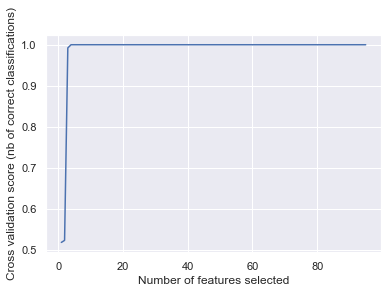

In [20]:
svc = SVC(kernel="linear")
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
min_feat = 1
rfecv = RFECV(estimator=svc, step=1, cv=cv, scoring='accuracy',
              min_features_to_select=min_feat, n_jobs=-1)
rfecv.fit(X,y)

print("Optimal number of features: %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_feat,
               len(rfecv.grid_scores_) + min_feat),
         rfecv.grid_scores_)
plt.show()

*Using a linear support vector machine as I know the data is highly clusterable

In [21]:
selector = RFE(svc, n_features_to_select=rfecv.n_features_)
selector = selector.fit(X, y)
select_features  = [i for i,j in zip(X.columns,selector.ranking_) if j==1]
X = X[select_features]
X.head(3)

,spore-print-color_r,P1_p,P3_p,P4_p
0,0,0,1,1
1,0,1,1,1
2,0,1,1,1


## 7. Model comparison

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #stratify important
print(X_train.shape)

(6499, 4)


In [23]:
classifiers = [
    (LogisticRegression(),"Log Regression"),
    (KNeighborsClassifier(),"KNN"),
    (SVC(kernel="linear"),"Linear SVM"),
    (SVC(),"RBF SVM"),
    (DecisionTreeClassifier(),"Decision Tree"),
    (RandomForestClassifier(),"Random Forest"),
    (MLPClassifier(),"Neural Network"),
    (AdaBoostClassifier(),"AdaBoost"),
    (GaussianNB(),"Naives Bayes"),
    (LinearDiscriminantAnalysis(),"LDA")]

comparedf = pd.DataFrame()

for clf, name in classifiers:
    now = time.time()
    
    model = clf
    model.fit(X_train, y_train)

    vals = {}
    expected = y_test
    predicted = model.predict(X_test)
    vals["Accuracy (Test)"] = "{:.2f}%".format(metrics.accuracy_score(expected, predicted)*100)
    expected = y_train
    predicted = model.predict(X_train)
    vals["Accuracy (Train)"] = "{:.2f}%".format(metrics.accuracy_score(expected, predicted)*100)
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    vals["Accuracy (CrossVal)"] = "{:.2f}%".format(scores.mean()*100)
    later = time.time()
    diff = '{:.3f}'.format(later-now)
    vals["Time"] = diff
    row = pd.DataFrame(vals,index=[name])
    comparedf = comparedf.append(row)

comparedf

,Accuracy (Test),Accuracy (Train),Accuracy (CrossVal),Time
Log Regression,99.82%,99.92%,99.92%,0.183
KNN,100.00%,100.00%,100.00%,1.657
Linear SVM,100.00%,100.00%,100.00%,0.113
RBF SVM,100.00%,100.00%,100.00%,0.111
Decision Tree,100.00%,100.00%,100.00%,0.064
Random Forest,100.00%,100.00%,100.00%,1.922
Neural Network,100.00%,100.00%,100.00%,34.687
AdaBoost,100.00%,100.00%,100.00%,1.838
Naives Bayes,100.00%,100.00%,100.00%,0.095
LDA,98.58%,98.51%,98.65%,0.154


## 8. Hyperparameter optimisation

### 8.1. Decision Tree

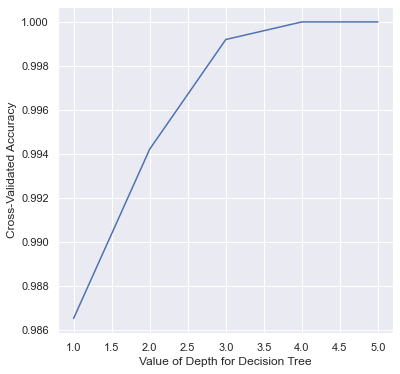

The best parameters are {'max_depth': 4} with a score of 1.00


In [24]:
# search for an optimal value of max-depth for Decision Tree
n_range = np.arange(1,6)
param_grid = dict(max_depth=n_range)

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
scores = grid.cv_results_['mean_test_score'].reshape(len(n_range))

plt.figure(figsize=(6,6))
plt.plot(n_range, scores)
plt.xlabel('Value of Depth for Decision Tree')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

### 8.2. Naives Bayes

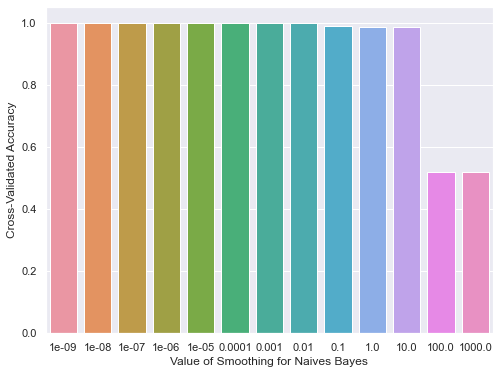

The best parameters are {'var_smoothing': 1e-09} with a score of 1.00


In [25]:
# search for an optimal value of var_smoothing for Naives Bayes
n_range = np.logspace(-9, 3, 13)
param_grid = dict(var_smoothing=n_range)

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
grid = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
scores = grid.cv_results_['mean_test_score'].reshape(len(n_range))

plt.figure(figsize=(8, 6))
sns.barplot(x=n_range, y=scores)
plt.xlabel('Value of Smoothing for Naives Bayes')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

### 8.3. RBF SVM

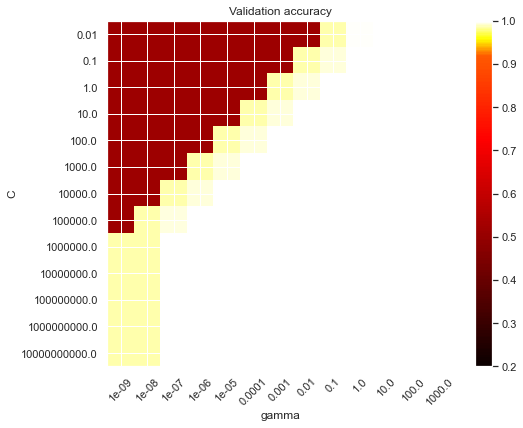

The best parameters are {'C': 0.01, 'gamma': 10.0} with a score of 1.00


In [26]:
class MidpointNormalise(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalise(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

## 9. Model selection

### 9.1. Decision Tree

In [27]:
# 10-fold cross-validation with the best Decision Tree model
decisiontree = DecisionTreeClassifier(max_depth=4)
now = time.time()
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
print("Accuracy(CrossVal) {:.2f}%".format(cross_val_score(decisiontree, X, y, cv=cv, scoring='accuracy').mean()*100))
later = time.time()
diff = '{:.3f}'.format(later-now)
print("Time taken: ", diff)

# make predictions
decisiontree.fit(X_train, y_train)
expected = y_test
predicted = decisiontree.predict(X_test)
# summarize the fit of the model
print("#"*55)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("Accuracy (Test)={:.2f}%".format(
metrics.accuracy_score(expected, predicted)*100))

Accuracy(CrossVal) 100.00%
Time taken:  0.060
#######################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

[[842   0]
 [  0 783]]
Accuracy (Test)=100.00%


### 9.2. Naives Bayes

In [28]:
# 10-fold cross-validation with the best Naives Bayes model
nb = GaussianNB(var_smoothing= 1e-9)
now = time.time()
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
print("Accuracy(CrossVal) {:.2f}%".format(cross_val_score(nb, X, y, cv=cv, scoring='accuracy').mean()*100))
later = time.time()
diff = '{:.3f}'.format(later-now)
print("Time taken: ", diff)

# make predictions
nb.fit(X_train, y_train)
expected = y_test
predicted = nb.predict(X_test)
# summarize the fit of the model
print("#"*55)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("Accuracy (Test)={:.2f}%".format(
metrics.accuracy_score(expected, predicted)*100))

Accuracy(CrossVal) 100.00%
Time taken:  0.063
#######################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

[[842   0]
 [  0 783]]
Accuracy (Test)=100.00%


### 9.3. RBF SVM 

In [29]:
# 10-fold cross-validation with the best RBF SVM model
svm = SVC(C=0.01, gamma=10.0)
now = time.time()
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
print("Accuracy(CrossVal) {:.2f}%".format(cross_val_score(svm, X, y, cv=cv, scoring='accuracy').mean()*100))
later = time.time()
diff = '{:.3f}'.format(later-now)
print("Time taken: ", diff)

# make predictions
svm.fit(X_train, y_train)
expected = y_test
predicted = svm.predict(X_test)
# summarize the fit of the model
print("#"*55)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("Accuracy (Test)={:.2f}%".format(
metrics.accuracy_score(expected, predicted)*100))

Accuracy(CrossVal) 100.00%
Time taken:  0.399
#######################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

[[842   0]
 [  0 783]]
Accuracy (Test)=100.00%


## 10. Evaluate model performance

### 10.1. Accuracy

In [30]:
# 10-fold cross-validation with the best Decision Tree model
decisiontree = DecisionTreeClassifier(max_depth=4)
decisiontree.fit(X_train, y_train)
expected = y_test
predicted = decisiontree.predict(X_test)
print('Expected:', expected[0:10])
print('Predicted:', predicted[0:10])
print("Accuracy: {:.2f}%".format(metrics.accuracy_score(expected, predicted)*100))

Expected: [1 1 0 1 1 0 0 0 0 1]
Predicted: [1 1 0 1 1 0 0 0 0 1]
Accuracy: 100.00%


### 10.2. Confusion matrix

In [31]:
confusion = metrics.confusion_matrix(expected, predicted)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(metrics.confusion_matrix(expected, predicted))
print("Accuracy: {:.2f}%".format(metrics.accuracy_score(expected, predicted)*100))
print("Sensitivity: {:.2f}%".format(metrics.recall_score(expected, predicted)*100))
print("Specificity: {:.2f}%".format(TN / (TN + FP)*100))
print("Matthews Corrcoef: {:.2f}%".format(metrics.matthews_corrcoef(expected, predicted)*100))

[[842   0]
 [  0 783]]
Accuracy: 100.00%
Sensitivity: 100.00%
Specificity: 100.00%
Matthews Corrcoef: 100.00%


### 10.3. ROC Curves

<Figure size 576x576 with 0 Axes>

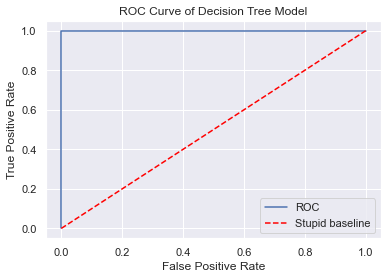

AUC/AUROC: 1.0


In [32]:
plt.figure(figsize=(8,8))
metrics.plot_roc_curve(decisiontree, X_test, y_test)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title("ROC Curve of Decision Tree Model")
plt.legend(["ROC","Stupid baseline"])
plt.show()
print("AUC/AUROC:",metrics.recall_score(expected, predicted)*TN / (TN + FP))

## 11. Conclusion

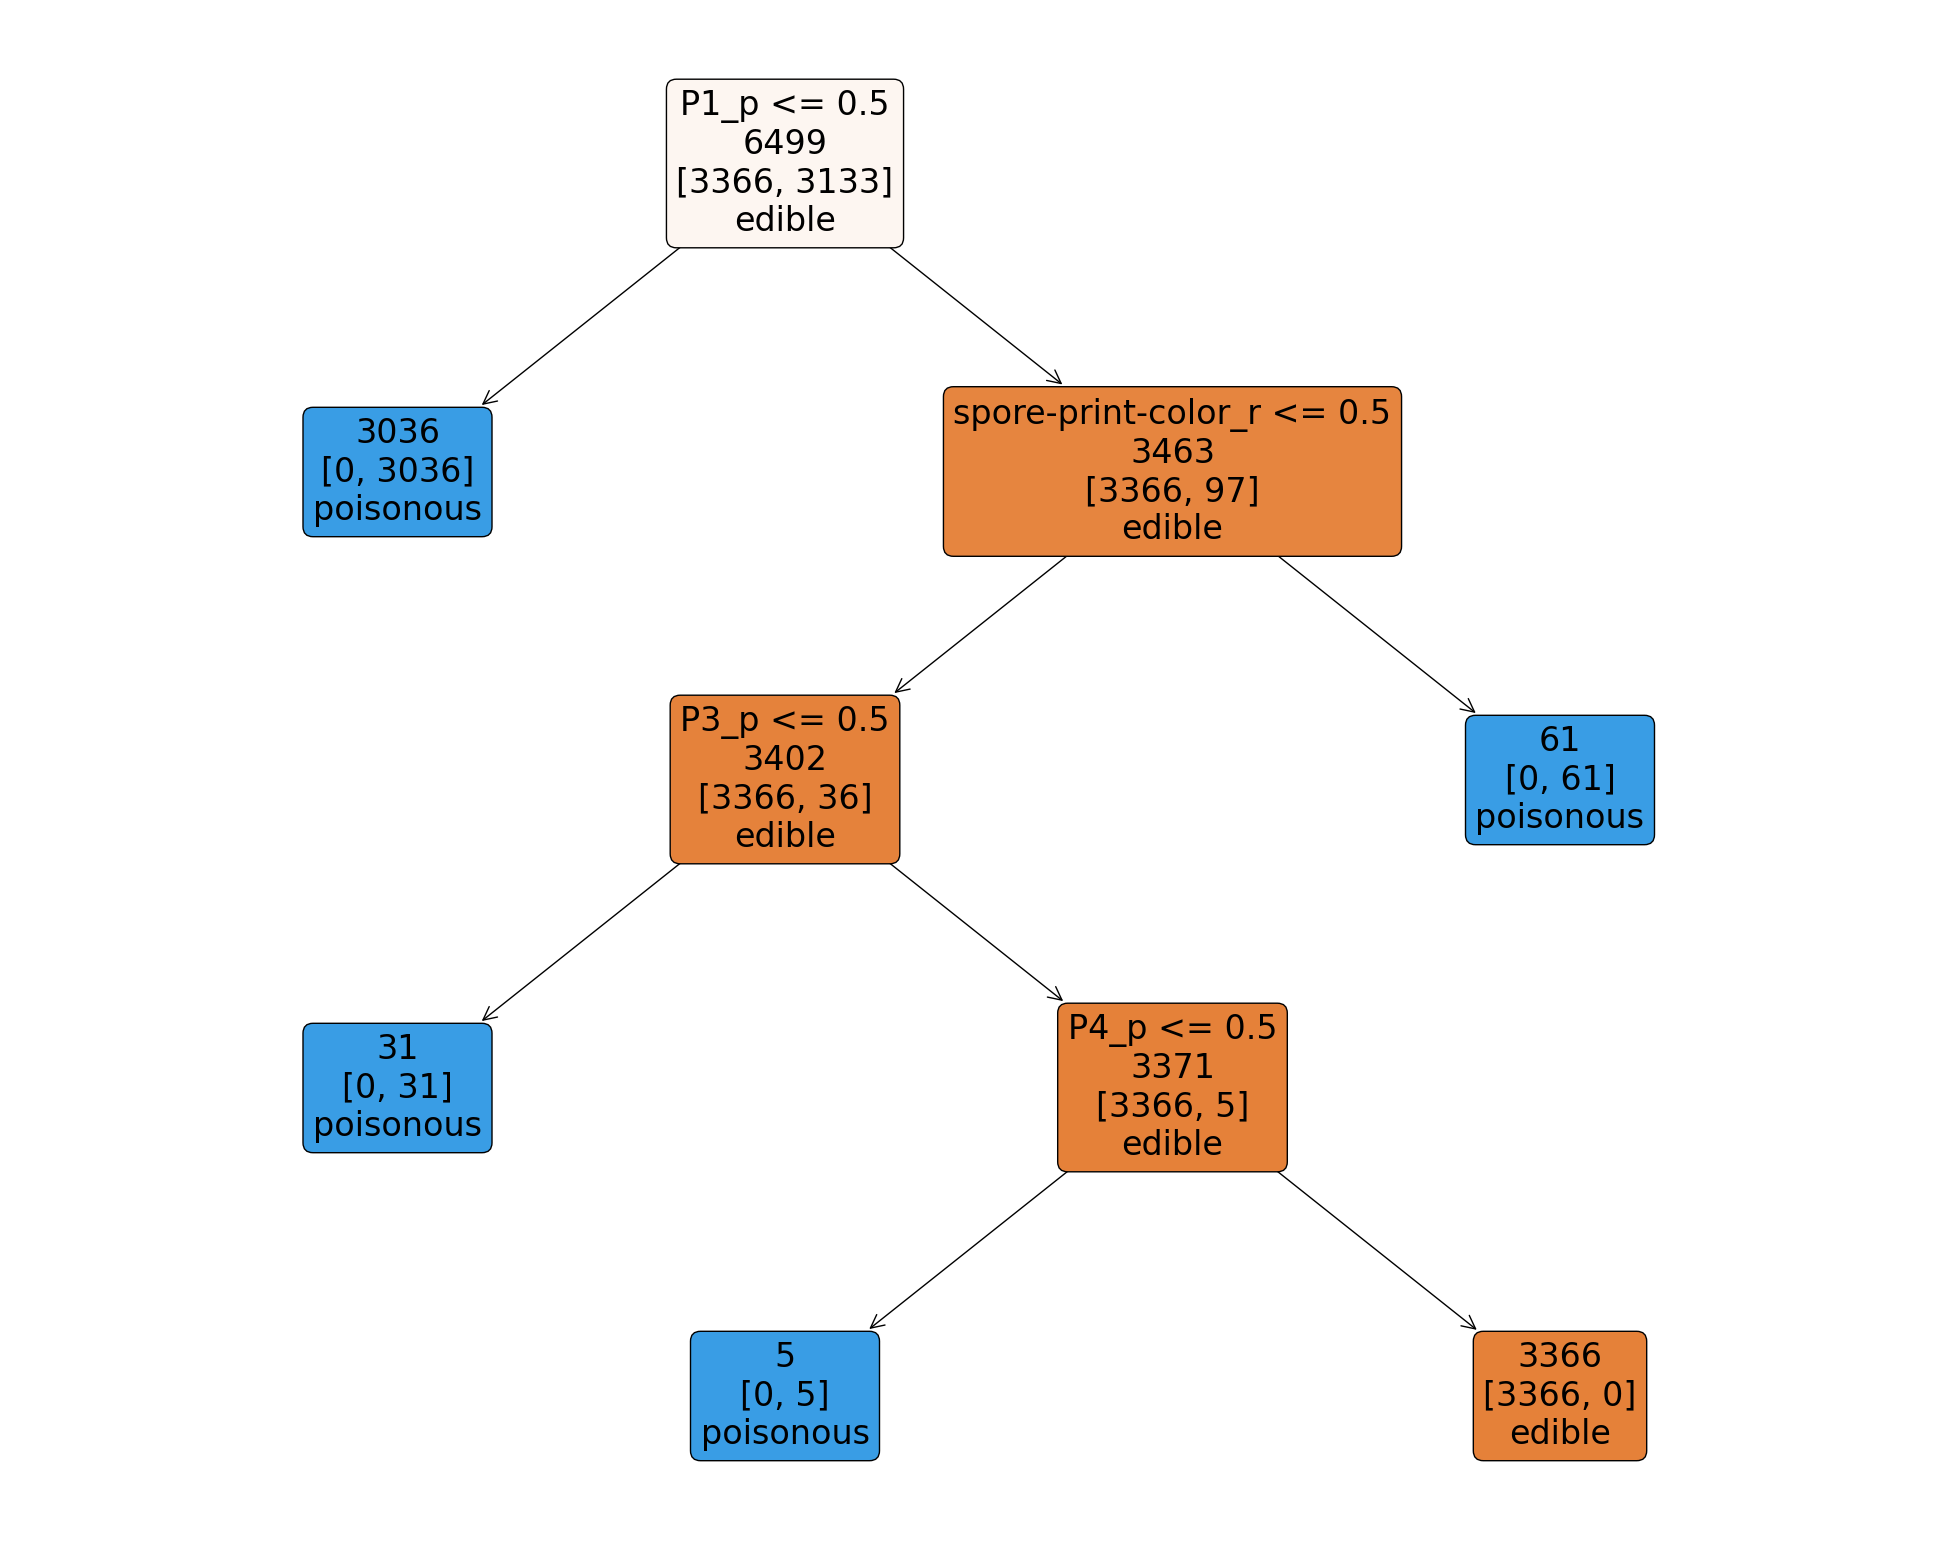

In [33]:
sns.reset_defaults()
fig = plt.figure(figsize=(25,20))
plot_tree(decisiontree, feature_names=X.columns, class_names=['edible','poisonous'],
          label='none', rounded=True, filled=True, fontsize=24, impurity=False)
fig.savefig("./decision_tree.png")
plt.show()

## 12. Report

**• How is your prediction task defined? And what is the meaning of the 
output variable?**<br>
My prediction task is to predict whether mushrooms in the Agaricus and Lepiota family would be edible or poisonous.<br>
The output variable 'e' means the mushroom is edible and safe to consume, whereas<br>
the output variable 'p' means the mushroom is poisonous/may be poisonous and unsafe to consume.<br>
(The target variables are later encoded into 0 if edible, 1 if poisonous to solve the classification task)

**• How do you represent your data as features?**<br>
I represented my data as features through the use of dummy variables (drop_first=True).<br>

**• Did you process the features in any way?**<br>
I feature engineered 4 additional features from my own background research.<br>
They are labelled P1 to P4 based on their rules.

**• Did you bring in any additional sources of data?**<br>
I did not bring in any additional sources of data.

**• How did you select which learning algorithms to use?**<br>
Through my Exploratory Data Analysis I found out that my data was highly<br>
clusterable so I picked multiple clustering models.<br>
I prioritise cross-val accuracy, and test against train accuracy.<br>
Thereafter comes time as many of the models scored perfect accuracies.

**• Did you try to tune the hyper parameters of the learning algorithm, and 
in that case how?**<br>
Yes I tuned the hyperparameters through looping them through variables and testing
out a range of values for specific parameters for each model

**• How do you evaluate the quality of your system?**<br>
I evaluate the quality of my system checking the accuracy, sensitivity, specificity and matthew corrcoef value

**• How well does your system compare to a stupid baseline?**<br>
My system performs the best it can be as it has a 100% accuracy whereas<br>
a stupid baseline will classify the mushrooms 50% accurate

**• Can you say anything about the errors that the system makes? For a 
classification task, you may consider a confusion matrix.**<br>
The system makes no errors. The confusion matrix projected shows that<br>
my system makes no false positives or true negatives.

**• Is it possible to say something about which features the model considers 
important? (Whether this is possible depends on the type of classifier 
you are using)**<br>
Yes. The model considers the features P1, spore_print_color_r, P3 and P4 the most important.<br>
This can be visualised under 11. Conclusion using the tree map as I have plotted graph.